In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure

#define plotting style that I like
style.use('fivethirtyeight')

In [2]:
#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

In [3]:
np_total=pd.read_csv('CSV_files/np.dat.csv')
pp_total=pd.read_csv('CSV_files/pp.dat.csv')
pp_total.rename(columns={' scattering_angle': 'scattering_angle', ' experimental_value': 'experimental_value', ' statistical_error': 'statistical_error', ' reaction_type': 'reaction_type', ' observable': 'observable', ' systematic_error': 'systematic_error', ' normalization': 'normalization'}, inplace=True)
np_total.rename(columns={' scattering_angle': 'scattering_angle', ' experimental_value': 'experimental_value', ' statistical_error': 'statistical_error', ' reaction_type': 'reaction_type', ' observable': 'observable', ' systematic_error': 'systematic_error', ' normalization': 'normalization'}, inplace=True)

In [4]:
# read separated files
#np files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')

#pp files
pp_sgt=pd.read_csv('CSV_files/pp.sgt.csv')
pp_sgtt=pd.read_csv('CSV_files/pp.sgtt.csv')

In [5]:
#remove uneccesary columns
#remove scattering angle because they are all 0 for sgt and sgtt
#total files
pp_total = pp_total.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])
np_total = np_total.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])
#np files
np_sgt = np_sgt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])
np_sgtt = np_sgtt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])
#pp files
pp_sgt = pp_sgt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])
pp_sgtt = pp_sgtt.drop(columns=['scattering_angle','statistical_error', 'systematic_error', 'normalization'])

In [6]:
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

In [7]:
# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K*experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K*experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)

In [8]:
change_np(np_sgt)
change_np(np_sgtt)
change_pp(pp_sgt)
change_pp(pp_sgtt)

In [9]:
pp_sgtt[['energy','experimental_value','K*experimental_value']]

,energy,experimental_value,K*experimental_value
0,202.699997,0.290,0.453198
1,295.000000,-0.367,-0.691894
2,304.000000,-1.590,-3.042963
3,325.100006,0.160,0.316659
4,328.000000,0.173,0.343911


### Generate Plots

In [10]:
def generate_plot(rxn_observable, reac_observ):
    #define values to be plotted
    energy=rxn_observable['energy']
    value=rxn_observable['experimental_value']
    k_value=rxn_observable['K*experimental_value']
    #figure specifications
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
    fig.autofmt_xdate(rotation = 45)
    fig.suptitle('Reaction_Observable: {}'.format(reac_observ), fontsize=24)
    #plot 1
    ax1.plot(energy, value, 'ro', alpha=0.5)
    ax1.set_xlabel('Energy'); ax1.set_ylabel('Experimental Value'); ax1.set_title('Experimental Value vs. Energy')
    #plot 2
    ax2.plot(k_value, value, 'bo', alpha=0.5)
    ax2.set_xlabel('K * Experimental Value'); ax2.set_ylabel('Experimental Value'); ax2.set_title('Experimental Value vs. Scattering Angle')
    #plot 3
    ax3.plot(k_value, energy, 'go', alpha=0.5)
    ax3.set_xlabel('K * Experimental Value'); ax3.set_ylabel('Energy'); ax3.set_title('K * Experimental Value vs. Energy')
    #plot 4
    ax4.plot(energy, k_value, 'mo', alpha=0.5)
    ax4.set_xlabel('Energy'); ax4.set_ylabel('K * Experimental Value'); ax4.set_title('Energy vs. K * Experimental Value')

In [11]:
## EVERYTHING THAT NEEDS CHANGED SHOULD BE IN HERE

#define rxn and observable for this round of calculations
rxn_observable=np_sgt
reac_observ='NP_SGT'

#define number of random states
number_of_random_states=10

#define intervals of test size
intervals=19 # 1:50%, 3:25%, 4:20%, 9:10%, 19:5%, 24:4%, 49:2%, 99:1%

In [12]:
# One-hot encode categorical features
rxn_observable = pd.get_dummies(rxn_observable)
# Labels are the values we want to predict
labels = np.array(rxn_observable['K*experimental_value'])
# Remove the labels from the features
# axis 1 refers to the columns
features = rxn_observable.drop('K*experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [13]:
def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #replace any test_labels=0 with small number to prevent dividing by 0
        #for index, value in enumerate(test_labels):
         #   if (value == 0):
          #      value=1e-3
           #     test_labels=np.where(test_labels==0, value, test_labels)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

Average Testing Score: [0.99930821 0.99437511 0.99707326 0.99662093 0.99755034 0.99805387
 0.99681887 0.99335435 0.9952969  0.98761964 0.98886213 0.98565107
 0.97557398 0.98836817 0.97464418 0.95056723 0.96434521 0.94084522
 0.93059063]
Testing Variance [0.00017176 0.01156254 0.002797   0.00590434 0.00178186 0.00198379
 0.00327095 0.00372296 0.00307287 0.01742971 0.0168677  0.02546267
 0.02975544 0.01294103 0.0286125  0.03008496 0.03194756 0.02465636
 0.01581163]

Average Training Score [0.99968375 0.99969004 0.99950807 0.99958529 0.99939638 0.99942558
 0.99901843 0.99895441 0.99865209 0.99836733 0.99808193 0.99780988
 0.99748333 0.99376755 0.99592474 0.99818632 0.99323815 0.99452317
 0.99640156]
Training Variance [1.32256568e-04 9.75386799e-05 2.30562968e-04 2.46774687e-04
 2.88844367e-04 2.47396205e-04 4.45003388e-04 6.01849678e-04
 9.00503089e-04 9.20399930e-04 1.37070526e-03 1.49035712e-03
 1.99298789e-03 2.72743883e-03 3.24453827e-03 1.68968595e-03
 6.48511835e-03 9.69975288e-03 8

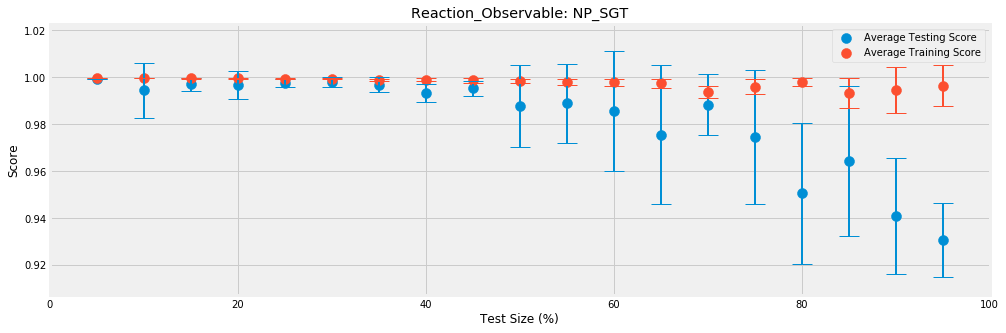

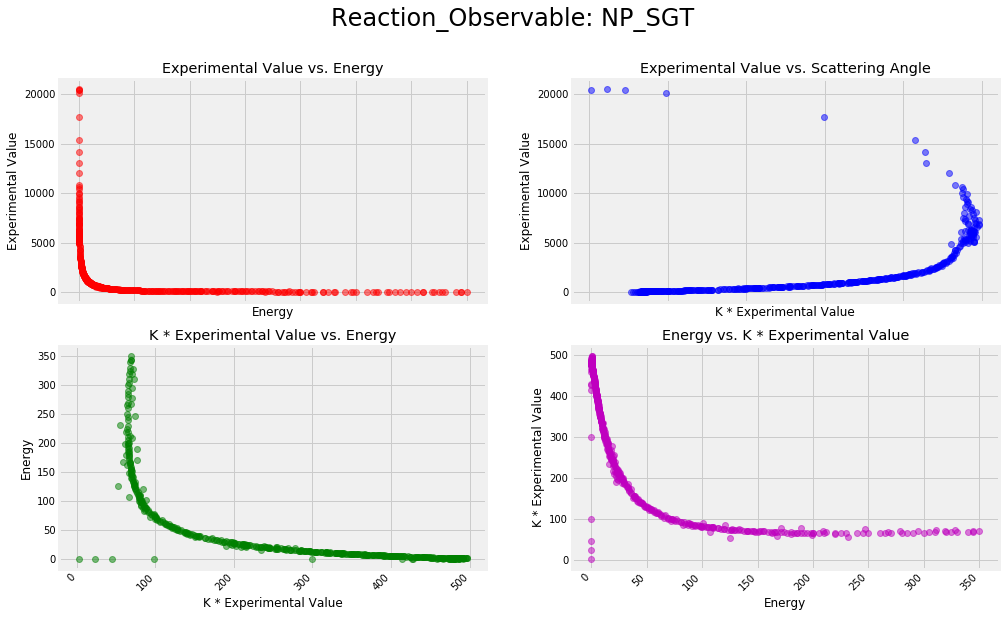

In [14]:
test_mean=np.zeros(intervals) 
train_mean=np.zeros(intervals) 
test_variance=np.zeros(intervals) 
train_variance=np.zeros(intervals) 
for i in range(intervals): 
    #define size
    size=(i+1)/(intervals+1)
    #call split function
    test, test_v, train, train_v = split_and_score(size, number_of_random_states)
    #add to arrays
    test_mean[i]=test
    train_mean[i]=train
    test_variance[i]=test_v
    train_variance[i]=train_v
print("Average Testing Score:", test_mean)
print('Testing Variance', test_variance)
print('')
print('Average Training Score', train_mean)
print('Training Variance', train_variance)
print('')

#plot 

#x-axis
if intervals==1:
    sample_size=[50] #50% intervals
elif intervals==3:
    sample_size=list(range(25,76,25)) #25% intervals
elif intervals==4:
    sample_size=list(range(20,81,20)) #20% intervals 
elif intervals==9:
    sample_size=list(range(10,91,10)) #10% intervals
elif intervals==19:
    sample_size=list(range(5,96,5)) #5% intervals
elif intervals==24:
    sample_size=list(range(4,97,4)) #4% intervals
elif intervals==49:
    sample_size=list(range(2,99,2)) #2% intervals
elif intervals==99:
    sample_size=list(range(1,100,1)) #1% intervals

#figure
figure(figsize=(15, 5))
ax=plt.subplot(111)
plt.xlabel('Test Size (%)')
plt.ylabel('Score')
plt.title("Reaction_Observable: {}".format(reac_observ))
plt.xlim(left=0, right=100)
ax.scatter(sample_size, test_mean, s=100, label='Average Testing Score')
ax.scatter(sample_size, train_mean, s=100, label='Average Training Score')
ax.errorbar(sample_size, test_mean, yerr=test_variance, linestyle='none', capsize=10, elinewidth=2)
ax.errorbar(sample_size, train_mean, yerr=train_variance, linestyle='none', capsize=10, elinewidth=2)
ax.legend(loc='best')
plt.show

generate_plot(rxn_observable, reac_observ)

In [15]:
#SGT: k*experimental_value=20*pi*(a+b)
#SGTT: k*experimental_value=-40*pi*(a-b)